In [1]:
from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import random

import collections
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer
import re
import itertools


import os
import gzip
import json
import time

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Helper libraries
from common import utils, vocabulary, models

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import surprise
from surprise.model_selection import KFold, train_test_split, GridSearchCV, cross_validate

from surprise import SVD
from surprise import Dataset
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import Reader
from surprise import accuracy

In [4]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df_ = {}
    for d in parse(path):
        df_[i] = d
        i += 1
    return pd.DataFrame.from_dict(df_, orient='index')

In [5]:
# reviews_Toys_and_Games.json.gz
print("Loading Toys and Games Review dataset:")
print()
# _f = 'reviews_Toys_and_Games_5.json.gz'
_f = 'reviews_Toys_and_Games.json.gz'

start = time.time()
fd = getDF(_f)
print('Total time taken for loading the toys and games reviews dataset :{} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print(fd.columns)
print()
print("Number of records in toys and games dataset: {}".format(len(fd)))
print()
fd.head(1)

Loading Toys and Games Review dataset:

Total time taken for loading the toys and games reviews dataset :3.0 minutes.

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Number of records in toys and games dataset: 2252771



,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AMEVO2LY6VEJA,0000191639,Nicole Soeder,"[0, 0]","Great product, thank you! Our son loved the pu...",5.0,Puzzles,1388016000,"12 26, 2013"


In [6]:
# meta_Toys_and_Games.json.gz
print("Loading related metadata dataset:")
print()
# file = 'metadata.json.gz'
file = 'meta_Toys_and_Games.json.gz'
start = time.time()
fd_ = getDF(file)
print('Total time taken for loading the metadata dataset: {} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print(fd_.columns)
print()
print("Number of records in metadata dataset: {}".format(len(fd_)))
print()
print(fd_.head(1))

Loading related metadata dataset:

Total time taken for loading the metadata dataset: 1.0 minutes.

Index(['asin', 'description', 'title', 'price', 'salesRank', 'imUrl', 'brand',
       'categories', 'related'],
      dtype='object')

Number of records in metadata dataset: 336072

         asin                                        description  \
0  0000191639  Three Dr. Suess' Puzzles: Green Eggs and Ham, ...   

                                            title  price  \
0  Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle  37.12   

                  salesRank  \
0  {'Toys & Games': 612379}   

                                               imUrl      brand  \
0  http://ecx.images-amazon.com/images/I/414PLROX...  Dr. Seuss   

                                  categories related  
0  [[Toys & Games, Puzzles, Jigsaw Puzzles]]     NaN  


In [7]:
print()
print("Number of NaN values in the Toy and Games dataset: \n", fd.isnull().sum())


Number of NaN values in the Toy and Games dataset: 
 reviewerID            0
asin                  0
reviewerName      11847
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
dtype: int64


In [8]:
print()
print("Number of NaN values in the metadata dataset: \n", fd_.isnull().sum())


Number of NaN values in the metadata dataset: 
 asin                0
description     33285
title             898
price           93381
salesRank        8849
imUrl             350
brand          150706
categories          0
related         71687
dtype: int64


In [9]:
print()
dframe = pd.merge(fd, fd_, on=['asin'], how='inner')
print("The number of records in the merged (Toys and Games + metadata) dataset: {}".format(len(dframe)))
print()
print("Number of unique items in toys and games reviews dataset: {}".format(fd.asin.nunique()))
print("Number of unique items in related metadata dataset: {}".format(fd_.asin.nunique()))
print("Number of unique items in merged dataframe: {}".format(dframe.asin.nunique()))
print()
dframe.head(1)


The number of records in the merged (Toys and Games + metadata) dataset: 2252771

Number of unique items in toys and games reviews dataset: 327698
Number of unique items in related metadata dataset: 336072
Number of unique items in merged dataframe: 327698



,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,description,title,price,salesRank,imUrl,brand,categories,related
0,AMEVO2LY6VEJA,0000191639,Nicole Soeder,"[0, 0]","Great product, thank you! Our son loved the pu...",5.0,Puzzles,1388016000,"12 26, 2013","Three Dr. Suess' Puzzles: Green Eggs and Ham, ...",Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle,37.12,{'Toys & Games': 612379},http://ecx.images-amazon.com/images/I/414PLROX...,Dr. Seuss,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]",NaN


In [10]:
print()
print("Number of NaN values in the merged dataset: \n", dframe.isnull().sum())


Number of NaN values in the merged dataset: 
 reviewerID             0
asin                   0
reviewerName       11847
helpful                0
reviewText             0
overall                0
summary                0
unixReviewTime         0
reviewTime             0
description        96987
title              19902
price             328463
salesRank          69573
imUrl               2969
brand             619365
categories             0
related           140210
dtype: int64


In [11]:
print("Missing {} values for 'imUrl'".format(dframe[dframe['imUrl'].isnull()].asin.nunique()))
print("Missing {} values for 'related'".format(dframe[dframe['related'].isnull()].asin.nunique()))
print("Missing {} values for 'categories'".format(dframe[dframe['categories'].isnull()].asin.nunique()))
print("Missing {} values for 'price'".format(dframe[dframe['price'].isnull()].asin.nunique()))

Missing 340 values for 'imUrl'
Missing 69962 values for 'related'
Missing 0 values for 'categories'
Missing 91635 values for 'price'


In [12]:
print()
print("Missing {} values from imUrl OR categories OR related OR price".format(len(dframe[dframe['imUrl'].isnull() | dframe['categories'].isnull() | dframe['related'].isnull() | dframe['price'].isnull()])))
print()
print("Missing {} values from imUrl & categories & related & price".format(len(dframe[dframe['imUrl'].isnull() & dframe['categories'].isnull() & dframe['related'].isnull() & dframe['price'].isnull()])))
print("Missing {} values from imUrl & categories & related".format(len(dframe[dframe['imUrl'].isnull() & dframe['categories'].isnull() & dframe['related'].isnull()])))
print("Missing {} values from imUrl & related & price".format(len(dframe[dframe['imUrl'].isnull() & dframe['related'].isnull() & dframe['price'].isnull()])))
print("Missing {} values from categories & related & price".format(len(dframe[dframe['categories'].isnull() & dframe['related'].isnull() & dframe['price'].isnull()])))
print("Missing {} values from related & price".format(len(dframe[dframe['related'].isnull() & dframe['price'].isnull()])))
print()
print("Missing {} values from imUrl & categories".format(len(dframe[dframe['imUrl'].isnull() & dframe['categories'].isnull()])))
print("Missing {} values from imUrl & related".format(len(dframe[dframe['imUrl'].isnull() & dframe['related'].isnull()])))
print("Missing {} values from imUrl & price".format(len(dframe[dframe['imUrl'].isnull() & dframe['price'].isnull()])))
print()
print("Missing {} values from categories & related".format(len(dframe[dframe['categories'].isnull() & dframe['related'].isnull()])))
print("Missing {} values from categories & price".format(len(dframe[dframe['categories'].isnull() & dframe['price'].isnull()])))
print()


Missing 361205 values from imUrl OR categories OR related OR price

Missing 0 values from imUrl & categories & related & price
Missing 0 values from imUrl & categories & related
Missing 2926 values from imUrl & related & price
Missing 0 values from categories & related & price
Missing 107468 values from related & price

Missing 0 values from imUrl & categories
Missing 2926 values from imUrl & related
Missing 2969 values from imUrl & price

Missing 0 values from categories & related
Missing 0 values from categories & price



In [13]:
print("There are {} items ('asin') with missing one or more values in one or more of the columns for ['imUrl', 'categories', 'related', 'price'].".format(len(set((((set(dframe[dframe['imUrl'].isnull()].asin).union(set(dframe[dframe['categories'].isnull()].asin)))).union(set(dframe[dframe['related'].isnull()].asin))).union(set(dframe[dframe['price'].isnull()].asin))))))

There are 112616 items ('asin') with missing one or more values in one or more of the columns for ['imUrl', 'categories', 'related', 'price'].


In [14]:
print()
print("Checking for missing values in the columns\n'['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']'' of the combined dataset:")

dframe__ = dframe[['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']]

dframe_ = dframe__.dropna(axis = 0, how='any',inplace=False)

print()
print("There are {} records with missing one or more values in one or more of the columns for - \n['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']".format(len(dframe__) - len(dframe_)))

dframe_.head()


Checking for missing values in the columns
'['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']'' of the combined dataset:

There are 361205 records with missing one or more values in one or more of the columns for - 
['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']


,reviewerID,asin,reviewText,overall,imUrl,categories,related,price
3,A2GGHHME9B6W4O,0131358936,This is a great tool for any teacher using the...,5.0,http://ecx.images-amazon.com/images/I/51%2B7Ej...,"[[Toys & Games, Learning & Education, Mathemat...","{'also_bought': ['0321845536', '0078787572'], ...",36.22
6,AYVR1MQCTNU5D,0375829695,What a great theme for a puzzle book. My daugh...,5.0,http://ecx.images-amazon.com/images/I/51Q02ZH6...,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]","{'also_viewed': ['1865036013', 'B004UB2DV4', '...",24.82
7,A3CJHKFHHQJP2K,0375829695,My son got this book for his birthday. He lov...,1.0,http://ecx.images-amazon.com/images/I/51Q02ZH6...,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]","{'also_viewed': ['1865036013', 'B004UB2DV4', '...",24.82
8,A3638FINP26E8N,0375829695,Love the book format. My 4yr old grandson love...,3.0,http://ecx.images-amazon.com/images/I/51Q02ZH6...,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]","{'also_viewed': ['1865036013', 'B004UB2DV4', '...",24.82
9,AUT7723O49VMN,0375829695,I'm a 2nd grade teacher. My students found th...,4.0,http://ecx.images-amazon.com/images/I/51Q02ZH6...,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]","{'also_viewed': ['1865036013', 'B004UB2DV4', '...",24.82


In [15]:
df_ = dframe_

In [16]:
df_.describe()

,overall,price
count,1.891566e+06,1.891566e+06
mean,4.181292e+00,3.419262e+01
std,1.256965e+00,5.599734e+01
min,1.000000e+00,0.000000e+00
25%,4.000000e+00,1.000000e+01
50%,5.000000e+00,1.876000e+01
75%,5.000000e+00,3.500000e+01
max,5.000000e+00,9.999900e+02


In [17]:
print("{}% of the ratings are 1".format(np.round(100*len(df_[df_.overall == 1])/(len(df_)), 2)))
print()
print("{}% of the ratings are 2".format(np.round(100*len(df_[df_.overall == 2])/(len(df_)), 2)))
print()
print("{}% of the ratings are 3".format(np.round(100*len(df_[df_.overall == 3])/(len(df_)), 2)))
print()
print("{}% of the ratings are 4".format(np.round(100*len(df_[df_.overall == 4])/(len(df_)), 2)))
print()
print("{}% of the ratings are 5".format(np.round(100*len(df_[df_.overall == 5])/(len(df_)), 2)))
print("-----")
print("{}".format(np.round(np.round(100*len(df_[df_.overall == 1])/(len(df_)), 2)+np.round(100*len(df_[df_.overall == 2])/(len(df_)), 2)+np.round(100*len(df_[df_.overall == 3])/(len(df_)), 2)+np.round(100*len(df_[df_.overall == 4])/(len(df_)), 2)+np.round(100*len(df_[df_.overall == 5])/(len(df_)), 2)),2))


8.05% of the ratings are 1

4.94% of the ratings are 2

8.47% of the ratings are 3

17.92% of the ratings are 4

60.62% of the ratings are 5
-----
100.0


In [18]:
print("Number of unique users = "+str(df_['reviewerID'].nunique()))
print("Number of unique users with more than 5 ratings = "+str((df_.groupby(['reviewerID'])['reviewerID'].count() > 5).sum()))
print("Number of unique users with more than 6 ratings = "+str((df_.groupby(['reviewerID'])['reviewerID'].count() > 6).sum()))
print("Number of unique users with 10 or more ratings = "+str((df_.groupby(['reviewerID'])['reviewerID'].count() >= 10).sum()))
print("Number of unique users with more than 10 ratings = "+str((df_.groupby(['reviewerID'])['reviewerID'].count() > 10).sum()))

Number of unique users = 1158972
Number of unique users with more than 5 ratings = 31172
Number of unique users with more than 6 ratings = 22323
Number of unique users with 10 or more ratings = 10561
Number of unique users with more than 10 ratings = 8655


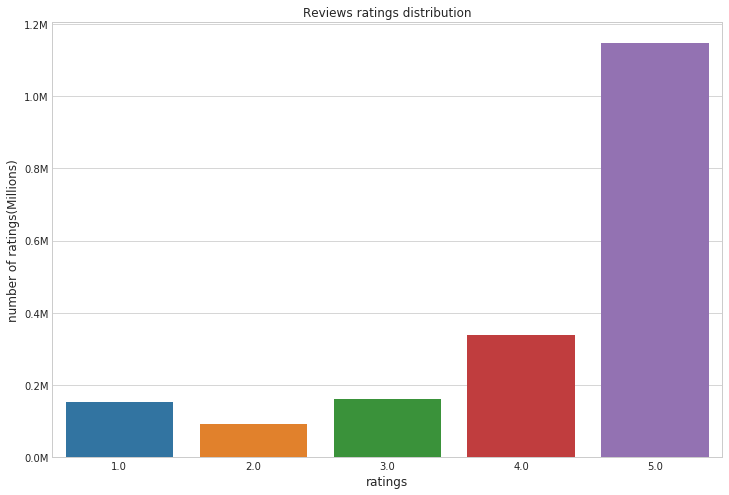

In [19]:
no_of_reviews_per_product = df_.groupby(by = 'asin')['overall'].count().sort_values(ascending = False)

no_of_reviews_per_user = df_.groupby(by = 'reviewerID')['overall'].count().sort_values(ascending = False)

plt.figure(figsize = (12, 8))
ax = sns.countplot(x="overall", data=df_)

ax.set_yticklabels([str(num/10**6) + "M" for num in ax.get_yticks()])

plt.tick_params(labelsize = 10)
plt.title("Reviews ratings distribution", fontsize = 12)
plt.xlabel("ratings", fontsize = 12)
plt.ylabel("number of ratings(Millions)", fontsize = 12)
plt.show()

Let’s see plot the distribution of rating frequency:

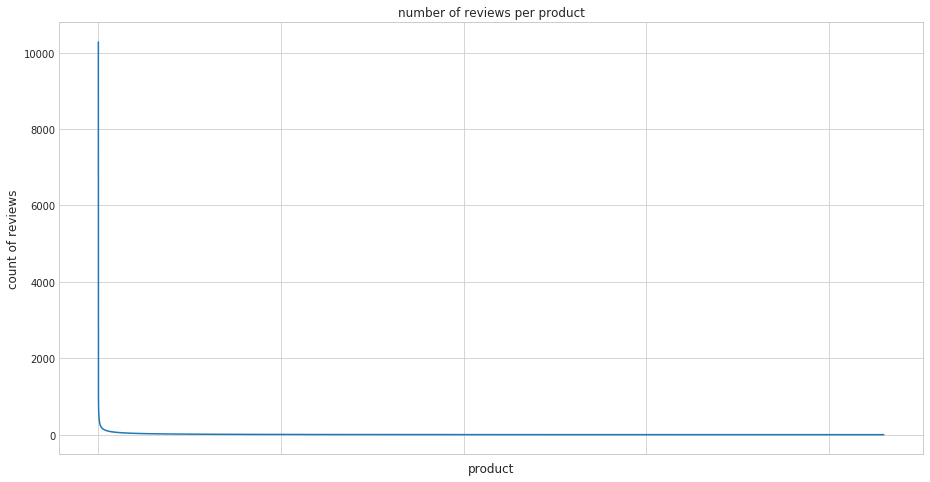

In [20]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("number of reviews per product", fontsize = 12)
plt.xlabel("product", fontsize = 12)
plt.ylabel("count of reviews", fontsize = 12)
plt.plot(no_of_reviews_per_product.values)
plt.tick_params(labelsize = 10)
axes.set_xticklabels([])
plt.show()

It is very skewed.

Rating Frequency is a _long tail_ distribution. Only a small fraction of the items are rated frequently. The vast majority of items are rated rarely.

Ratings data is very sparse and data points are mostly related to a few very popular products and also by highly engaged users. Large amount of items don’t have ratings at all.

These sparse ratings are less predictable for most users and highly sensitive to an individual users who might review very obscure products which makes the pattern very noisy. 

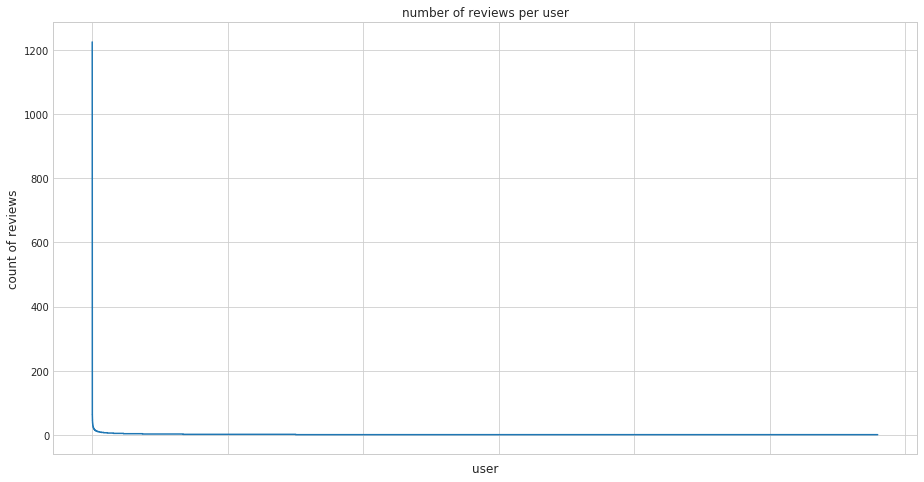

In [21]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("number of reviews per user", fontsize = 12)
plt.xlabel("user", fontsize = 12)
plt.ylabel("count of reviews", fontsize = 12)
plt.plot(no_of_reviews_per_user.values)
plt.tick_params(labelsize = 10)
axes.set_xticklabels([])
plt.show()

In [22]:
quantiles = no_of_reviews_per_user.quantile(np.arange(0,1.01,0.01))

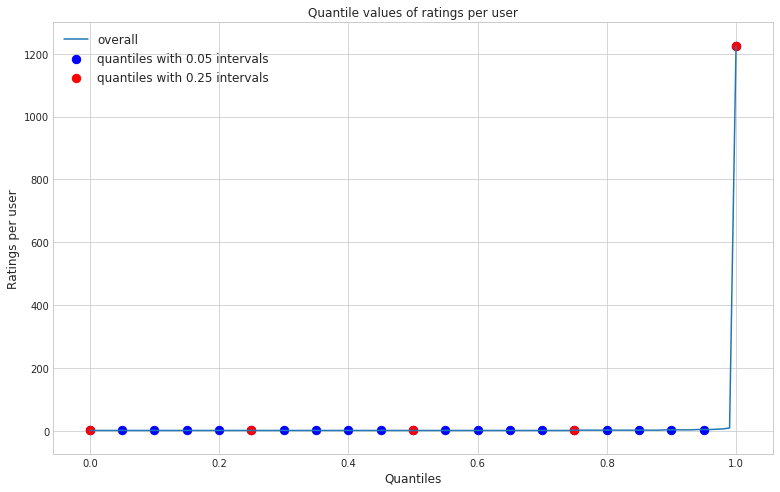

In [23]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of ratings per user", fontsize = 12)
axes.set_xlabel("Quantiles", fontsize = 12)
axes.set_ylabel("Ratings per user", fontsize = 12)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5],  y = quantiles.values[::5],  c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red",  s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 12)
    
axes.tick_params(labelsize = 10)

In [24]:
print("Number of not null entries in the dataframe:\n", df_[df_['related'].notnull()].count())
print("Number of null entries in the dataframe:\n", df_[df_['related'].isnull()].count())
print("Total entries in the dataframe:", len(df_))
print()
df_[df_['related'].notnull()].related.apply(lambda x: x.keys())

Number of not null entries in the dataframe:
 reviewerID    1891566
asin          1891566
reviewText    1891566
overall       1891566
imUrl         1891566
categories    1891566
related       1891566
price         1891566
dtype: int64
Number of null entries in the dataframe:
 reviewerID    0
asin          0
reviewText    0
overall       0
imUrl         0
categories    0
related       0
price         0
dtype: int64
Total entries in the dataframe: 1891566



3                     (also_bought, buy_after_viewing)
6                                        (also_viewed)
7                                        (also_viewed)
8                                        (also_viewed)
9                                        (also_viewed)
10                                       (also_viewed)
11                                       (also_viewed)
12                                       (also_viewed)
13                                       (also_viewed)
14                                       (also_viewed)
26                                 (buy_after_viewing)
27                                 (buy_after_viewing)
28                          (also_bought, also_viewed)
29                      (also_viewed, bought_together)
30                          (also_bought, also_viewed)
31                          (also_bought, also_viewed)
33                                       (also_viewed)
34         (also_bought, also_viewed, bought_together)
35        

In [25]:
_df = df_[df_['related'].notnull()]
_df.head()

,reviewerID,asin,reviewText,overall,imUrl,categories,related,price
3,A2GGHHME9B6W4O,0131358936,This is a great tool for any teacher using the...,5.0,http://ecx.images-amazon.com/images/I/51%2B7Ej...,"[[Toys & Games, Learning & Education, Mathemat...","{'also_bought': ['0321845536', '0078787572'], ...",36.22
6,AYVR1MQCTNU5D,0375829695,What a great theme for a puzzle book. My daugh...,5.0,http://ecx.images-amazon.com/images/I/51Q02ZH6...,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]","{'also_viewed': ['1865036013', 'B004UB2DV4', '...",24.82
7,A3CJHKFHHQJP2K,0375829695,My son got this book for his birthday. He lov...,1.0,http://ecx.images-amazon.com/images/I/51Q02ZH6...,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]","{'also_viewed': ['1865036013', 'B004UB2DV4', '...",24.82
8,A3638FINP26E8N,0375829695,Love the book format. My 4yr old grandson love...,3.0,http://ecx.images-amazon.com/images/I/51Q02ZH6...,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]","{'also_viewed': ['1865036013', 'B004UB2DV4', '...",24.82
9,AUT7723O49VMN,0375829695,I'm a 2nd grade teacher. My students found th...,4.0,http://ecx.images-amazon.com/images/I/51Q02ZH6...,"[[Toys & Games, Puzzles, Jigsaw Puzzles]]","{'also_viewed': ['1865036013', 'B004UB2DV4', '...",24.82


In [26]:
_df['also_viewed'] = ""
_df['also_bought'] = ""
_df['bought_together'] = ""
_df['buy_after_viewing'] = "" 

start = time.time()
for i, row in _df.iterrows():
    for key, val in row['related'].items():
        _df.at[i, key] = val
print("total time taken to parse 'related' signals into separate columns: {} minutes".format(np.round((time.time() - start)/60,2)))
_df.dtypes

total time taken to parse 'related' signals into separate columns: 3.27 minutes


reviewerID            object
asin                  object
reviewText            object
overall              float64
imUrl                 object
categories            object
related               object
price                float64
also_viewed           object
also_bought           object
bought_together       object
buy_after_viewing     object
dtype: object

In [27]:
print(len(_df[(_df['also_viewed'].values != '') & (_df['also_bought'].values != '') & (_df['buy_after_viewing'].values != '') & (_df['bought_together'].values != '')][['asin', 'also_viewed', 'also_bought', 'buy_after_viewing', 'bought_together']]))
print()
_df[(_df['also_viewed'].values != '') & (_df['also_bought'].values != '') & (_df['buy_after_viewing'].values != '') & (_df['bought_together'].values != '')][['asin', 'also_viewed', 'also_bought', 'buy_after_viewing', 'bought_together']]

8931



,asin,also_viewed,also_bought,buy_after_viewing,bought_together
38618,B00000IS5R,"[B001ECI9EM, B000IBPD76, B002JWOKF8, 073533346...","[B000GCKDPE, B001ECI9EM, B000N178E2, B0015KGFQ...","[B001ECI9EM, B000IBPD76, B000N178E2, B002JWOKF8]",[B000GCKDPE]
38619,B00000IS5R,"[B001ECI9EM, B000IBPD76, B002JWOKF8, 073533346...","[B000GCKDPE, B001ECI9EM, B000N178E2, B0015KGFQ...","[B001ECI9EM, B000IBPD76, B000N178E2, B002JWOKF8]",[B000GCKDPE]
38620,B00000IS5R,"[B001ECI9EM, B000IBPD76, B002JWOKF8, 073533346...","[B000GCKDPE, B001ECI9EM, B000N178E2, B0015KGFQ...","[B001ECI9EM, B000IBPD76, B000N178E2, B002JWOKF8]",[B000GCKDPE]
38621,B00000IS5R,"[B001ECI9EM, B000IBPD76, B002JWOKF8, 073533346...","[B000GCKDPE, B001ECI9EM, B000N178E2, B0015KGFQ...","[B001ECI9EM, B000IBPD76, B000N178E2, B002JWOKF8]",[B000GCKDPE]
38622,B00000IS5R,"[B001ECI9EM, B000IBPD76, B002JWOKF8, 073533346...","[B000GCKDPE, B001ECI9EM, B000N178E2, B0015KGFQ...","[B001ECI9EM, B000IBPD76, B000N178E2, B002JWOKF8]",[B000GCKDPE]
68328,B00001P4QK,"[B004C7QNCQ, B00000IRKL, B000OP1YWO, B001ESA66...","[B004NCEL4M, B006GCRJ9Q, B002NQJ45Q, B00004XOW...","[B004C7QNCQ, B00000IRKL, B000OP1YWO, B000SONEQA]","[B007GE75HY, B0089W1IGG]"
68329,B00001P4QK,"[B004C7QNCQ, B00000IRKL, B000OP1YWO, B001ESA66...","[B004NCEL4M, B006GCRJ9Q, B002NQJ45Q, B00004XOW...","[B004C7QNCQ, B00000IRKL, B000OP1YWO, B000SONEQA]","[B007GE75HY, B0089W1IGG]"
68330,B00001P4QK,"[B004C7QNCQ, B00000IRKL, B000OP1YWO, B001ESA66...","[B004NCEL4M, B006GCRJ9Q, B002NQJ45Q, B00004XOW...","[B004C7QNCQ, B00000IRKL, B000OP1YWO, B000SONEQA]","[B007GE75HY, B0089W1IGG]"
68331,B00001P4QK,"[B004C7QNCQ, B00000IRKL, B000OP1YWO, B001ESA66...","[B004NCEL4M, B006GCRJ9Q, B002NQJ45Q, B00004XOW...","[B004C7QNCQ, B00000IRKL, B000OP1YWO, B000SONEQA]","[B007GE75HY, B0089W1IGG]"
68332,B00001P4QK,"[B004C7QNCQ, B00000IRKL, B000OP1YWO, B001ESA66...","[B004NCEL4M, B006GCRJ9Q, B002NQJ45Q, B00004XOW...","[B004C7QNCQ, B00000IRKL, B000OP1YWO, B000SONEQA]","[B007GE75HY, B0089W1IGG]"


In [28]:
print("Total number of records in the joint dataset: {}".format(len(_df)))
print()
print("Number of records with non-empty values in the 'also_bought' column: {}".format((_df['also_bought'].apply(lambda x: len(x)).values != 0).sum()))
print("Number of records with empty values in the 'also_bought' column: {}".format((len(_df) - len(_df[_df['also_bought'] != '']))))
print("Total of records in the 'also_bought' column: {}".format((len(_df[_df['also_bought'] == '']) + len(_df[_df['also_bought'] != '']))))
print()
print("Number of records with non-empty values in the 'also_viewed' column: {}".format((_df['also_viewed'].apply(lambda x: len(x)).values != 0).sum()))
print("Number of records with empty values in the 'also_viewed' column: {}".format((len(_df) - len(_df[_df['also_viewed'] != '']))))
print("Total of records in the 'also_viewed' column: {}".format((len(_df[_df['also_viewed'] == '']) + len(_df[_df['also_viewed'] != '']))))
print()
print("Number of records with non-empty values in the 'buy_after_viewing' column: {}".format((_df['buy_after_viewing'].apply(lambda x: len(x)).values != 0).sum()))
print("Number of records with empty values in the 'buy_after_viewing' column: {}".format((len(_df) - len(_df[_df['buy_after_viewing'] != '']))))
print("Total of records in the 'buy_after_viewing' column: {}".format((len(_df[_df['buy_after_viewing'] == '']) + len(_df[_df['buy_after_viewing'] != '']))))
print()
print("Number of records with non-empty values in the 'bought_together' column: {}".format((_df['bought_together'].apply(lambda x: len(x)).values != 0).sum()))
print("Number of records with empty values in the 'bought_together' column: {}".format((len(_df) - len(_df[_df['bought_together'] != '']))))
print("Total of records in the 'bought_together' column: {}".format((len(_df[_df['bought_together'] == '']) + len(_df[_df['bought_together'] != '']))))


Total number of records in the joint dataset: 1891566

Number of records with non-empty values in the 'also_bought' column: 1707516
Number of records with empty values in the 'also_bought' column: 184050
Total of records in the 'also_bought' column: 1891566

Number of records with non-empty values in the 'also_viewed' column: 1843037
Number of records with empty values in the 'also_viewed' column: 48529
Total of records in the 'also_viewed' column: 1891566

Number of records with non-empty values in the 'buy_after_viewing' column: 47941
Number of records with empty values in the 'buy_after_viewing' column: 1843625
Total of records in the 'buy_after_viewing' column: 1891566

Number of records with non-empty values in the 'bought_together' column: 1717567
Number of records with empty values in the 'bought_together' column: 173999
Total of records in the 'bought_together' column: 1891566


In [29]:
_df['buy_t'] = ""
_df['buy_r'] = ""
_df['buy_av'] = ""
_df['buy_ab'] = ""

start = time.time()
for i, row in _df.iterrows():
    if (row['asin'] in row['bought_together']):
        _df.at[i, "buy_t"] = 1
    if (row['asin'] in row['buy_after_viewing']):
        _df.at[i, "buy_r"] = 1
    if (row['asin'] in row['also_bought']):
        _df.at[i, "buy_ab"] = 1
    if (row['asin'] in row['also_viewed']):
        _df.at[i, "buy_av"] = 1
        
print("total time taken to extract buy signals from 'related' column: {} minutes".format(np.round((time.time() - start)/60,2)))

total time taken to extract buy signals from 'related' column: 3.73 minutes


In [30]:
print("Number of times a reviewed item is in 'bought_together':", (_df.buy_t.values == 1).sum())
print("Number of times a reviewed item is in 'buy_after_viewing':", (_df.buy_r.values == 1).sum())
print("Number of times a reviewed item is in 'also bought':", (_df.buy_ab.values == 1).sum())
print("Number of times a reviewed item is in 'also viewed':", (_df.buy_av.values == 1).sum())

Number of times a reviewed item is in 'bought_together': 0
Number of times a reviewed item is in 'buy_after_viewing': 0
Number of times a reviewed item is in 'also bought': 8
Number of times a reviewed item is in 'also viewed': 5


In [31]:
# _df['also_viewed'].values
max_also_reviewed = max(_df['also_viewed'].apply(lambda x: len(x)))
print(max_also_reviewed)
max_also_bought = max(_df['also_bought'].apply(lambda x: len(x)))
print(max_also_bought)
max_bought_together = max(_df['bought_together'].apply(lambda x: len(x)))
print(max_bought_together)
max_buy_after_viewing = max(_df['buy_after_viewing'].apply(lambda x: len(x)))
print(max_buy_after_viewing)

60
100
4
6


In [32]:
# An example with specific reviewerID and specific item in the dataframe:
_df[(_df['reviewerID'] == 'AVJ4N5LBKAOG5') & (_df['asin'] == 'B00LOYLHOE')]

,reviewerID,asin,reviewText,overall,imUrl,categories,related,price,also_viewed,also_bought,bought_together,buy_after_viewing,buy_t,buy_r,buy_av,buy_ab
2252764,AVJ4N5LBKAOG5,B00LOYLHOE,"When I was a kid, I always heard, and sometime...",5.0,http://ecx.images-amazon.com/images/I/418neZCc...,"[[Toys & Games, Hobbies, RC Vehicles & Parts, ...","{'also_viewed': ['B00D3IN11Q', 'B00EXBDWZC', '...",99.99,"[B00D3IN11Q, B00EXBDWZC, B00LBI9BKA, B00KI03U8...",,,,,,,


In [33]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

In [34]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(_df[['reviewerID', 'asin', 'overall']], reader)

In [39]:
# sample random trainset and testset
# test set is made of 30% of the ratings.
trainset, testset = train_test_split(data, test_size=.30)
# held_out_set, test_set = train_test_split(held_test_set, test_size=.50)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.1496


1.1496051160011092

In [43]:
start = time.time()

param_grid = {'n_epochs':[10], 'n_factors': [10, 40], 'lr_all': [0.001, 0.005, 0.01, 0.1],
              'reg_all': [0.01, 0.02, 0.05, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

print("total time taken to search best parameters: {} minutes".format(np.round((time.time() - start)/60,2)))

1.146404788465116
{'n_epochs': 10, 'n_factors': 10, 'lr_all': 0.01, 'reg_all': 0.05}
total time taken to search best parameters: 20.44 minutes


In [46]:
trainset = data.build_full_trainset()
model = SVD(n_epochs = gs.best_params['rmse']['n_epochs'], n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']['lr_all'], reg_all = gs.best_params['rmse']['reg_all'], verbose = True)
out = model.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
